# MLP From Scratch

In this notebook, we'll create a Multi Layered Perceptron which is the simplest possible type of neural newtorks without using any pre made neural network framework.

We'll be modelling it on the wine quality dataset to classify different grades of wine.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## Data Import And Preprocessing.

We have the dataset split in two files for white and red wines separately. We'll combine the datasets and normalize all the data for initial MLP preparation.

In [2]:
data_white = pd.read_csv("WineDataset/winequality-white.csv", delimiter=";")
data_red = pd.read_csv("WineDataset/winequality-red.csv", delimiter=";")

data_white["is_red"] = 0
data_red["is_red"] = 1

data = pd.concat([data_white, data_red])

X = data.drop(columns="quality").values

Y = data["quality"].values


### Normalization
We'll normalize the data, and also one hot encode the quality to fit to the neural network

In [3]:
def z_score_normalize(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X_scaled = (X - mean) / std
    return mean, std, X_scaled

def one_hot_encode(y, n_classes):
    m = y.shape[0]
    Y_onehot = np.zeros((m, n_classes))
    Y_onehot[np.arange(m), y] = 1
    return Y_onehot

X = z_score_normalize(X)[2]
Y = one_hot_encode(Y, 10) # 0 - 9 classes

### Train - test Split

We'll split our dataset into training and testing datasets.

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

## Architecture Design
Here we'll design our model.
We'll define our model, set all the parameters and initialize the values using He Initialization.
### Hyperparameters

In [5]:
n_input = 12
n_hidden_1 = 250
n_hidden_2 = 250
n_output = 10 # 0 - 9 possible quality in the dataset
alpha = 0.1 #Learning Rate
n_epochs = 300

### Parameter Initialization

In [6]:
def he_initialization(shape):
    fan_in = shape[0]
    std = np.sqrt(2.0 / fan_in)
    return np.random.randn(*shape) * std

def initiaize_wb(n_in, n_out, *n_hidden):
    if len(n_hidden) == 0:
        W = [he_initialization((n_in, n_out))]
        B = [he_initialization((1, n_out))]
    else:
        W = []
        B = []
        for i in range(len(n_hidden)+1):
            if i==len(n_hidden):
                W.append(he_initialization((n_hidden[i-1], n_out)))
                B.append(he_initialization((1, n_out)))
            elif i==0:
                W.append(he_initialization((n_in, n_hidden[i])))
                B.append((he_initialization((1, n_hidden[i]))))
            else:
                W.append(he_initialization((n_hidden[i-1], n_hidden[i])))
                B.append(he_initialization((1, n_hidden[i])))

    return W, B


## Mathematical Implementation

Since we're going with a very basic implementation, we'll now define the base mathematical function required to train the models.
We'll have functions for the forward propagation, use sparse categorical-cross entropy as loss function. We'll aslo defin the backpropagation functions which were derived using the chain rules.

### Forward Propagation

In [7]:
def calculate_activation(w, x, b):
    z = x @ w + b
    return z

def relu(z):
    a = np.maximum(0, z)
    return a

def softmax(z):
    shifted = z - np.max(z, axis=-1, keepdims=True)
    exp_scores = np.exp(shifted)
    return exp_scores / np.sum(exp_scores, axis=-1, keepdims=True)

def forward_prop(X, W, B):
    A = []
    Z = []

    for i in range(len(W)):
        if i == 0:
            Z.append(calculate_activation(W[i], X, B[i]))
            A.append(relu(Z[-1]))
        elif i == len(W)-1:
            Z.append(calculate_activation(W[i], A[-1], B[i]))
            A.append(softmax(Z[-1]))
        else:
            Z.append(calculate_activation(W[i], A[-1], B[i]))
            A.append(relu(Z[-1]))

    return A, Z



### Loss Function

In [8]:
def categorical_cross_entropy(y, A):
    m = y.shape[0]
    eps = 1e-12
    A = np.clip(A, eps, 1 - eps)

    loss = -np.sum(y*np.log(A)) / m

    return loss

### Backpropagation

In [9]:
def relu_derivative(z):
    return z>0

def backpropagation(X, Y, Z, A):
    m = Y.shape[0]
    d_z = []
    d_w = []
    d_b = []
    for i in range(len(A)-1, -1, -1):
        if i==len(A)-1:
            d_z.insert(0, A[-1] - Y) # Since derivative of softmax actually cancels out
            d_w.insert(0, (A[-2].T @ d_z[0]) / m)
            d_b.insert(0, np.sum(d_z[0], axis=0, keepdims=True) / m)
        elif i==0:
            d_z.insert(0, (d_z[0] @ W[1].T) * relu_derivative(Z[0]))
            d_w.insert(0, (X.T @ d_z[0]) / m)
            d_b.insert(0, np.sum(d_z[0], axis=0, keepdims=True) / m)
        else:
            d_z.insert(0, (d_z[0] @ W[i+1].T) * relu_derivative(Z[i]))
            d_w.insert(0, (A[i-1].T @ d_z[0]) / m)
            d_b.insert(0, np.sum(d_z[0], axis=0, keepdims=True) / m)
    
    return d_w, d_b


## Training Loop

We'll now define functions for our training loop and train our MLP on the data.

### Parameter Update Rules

In [10]:
def update_params(W, B, d_w, d_b, alpha):
    for i in range(len(W)):
        W[i] = W[i] - alpha * d_w[i]
        B[i] = B[i] - alpha * d_b[i]
    
    return W, B

### Training Loop

Epoch 30/300, Loss: 1.2093672903561918
Epoch 60/300, Loss: 1.1959082864700432
Epoch 90/300, Loss: 1.0969757370361186
Epoch 120/300, Loss: 1.0577549808526348
Epoch 150/300, Loss: 1.0721497561484186
Epoch 180/300, Loss: 1.03110388896688
Epoch 210/300, Loss: 1.0217506818902222
Epoch 240/300, Loss: 0.9997609012343502
Epoch 270/300, Loss: 0.989442858042646
Epoch 300/300, Loss: 0.9844879403182495


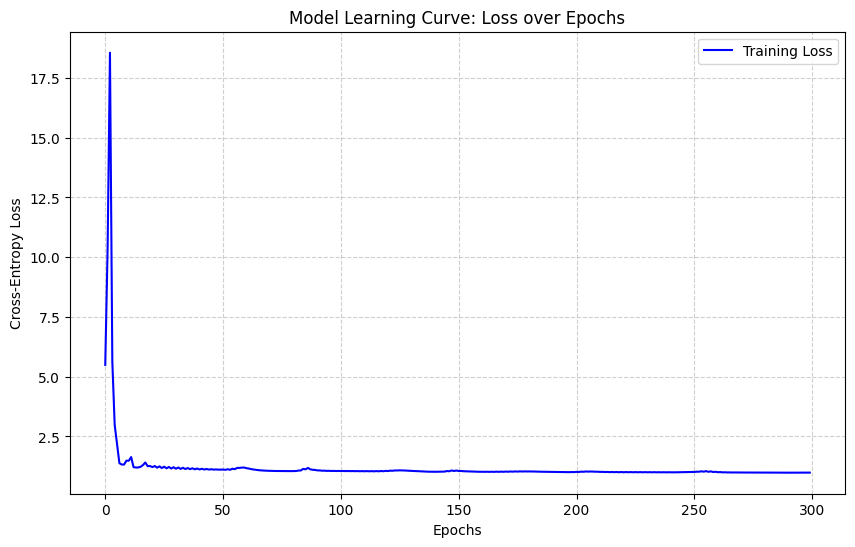

In [11]:
W, B = initiaize_wb(n_input, n_output, n_hidden_1, n_hidden_2)

loss_history = []

for i in range(n_epochs):
    A, Z = forward_prop(X_train, W, B)
    d_W, d_B = backpropagation(X_train, Y_train, Z, A)
    W, B = update_params(W, B, d_W, d_B, alpha)
    loss = categorical_cross_entropy(Y_train, A[-1])
    loss_history.append(loss)
    if (i+1) % (n_epochs/10) == 0:
        print("Epoch {}/{}, Loss: {}".format(i+1, n_epochs, loss))

plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Training Loss', color='blue')
plt.title('Model Learning Curve: Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


## Evaluation

We'll now go for evaluation the model on our test set

In [12]:
def get_predictions(X, W, B):
    A, _ = forward_prop(X, W, B)
    probs = A[-1]

    y_pred = np.argmax(probs, axis=1)
    return y_pred

y_pred = get_predictions(X_test, W, B)
y_true = np.argmax(Y_test, axis=1)

print("Classification Report\n")
print(classification_report(y_true, y_pred, zero_division=0))

Classification Report

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         9
           4       0.29      0.04      0.06        57
           5       0.54      0.78      0.63       432
           6       0.55      0.54      0.55       558
           7       0.56      0.32      0.41       213
           8       0.00      0.00      0.00        29
           9       0.00      0.00      0.00         2

    accuracy                           0.54      1300
   macro avg       0.28      0.24      0.24      1300
weighted avg       0.52      0.54      0.52      1300



## Conclusion

As we can see from our classification report, our model reaches an accuracy of 54% which is fairly good considering it is near to what the original research paper was able to achieve. However a pretty low precision  and low f1 score towards less dominant classes means that hte model has learned to be heavily biased towards 5, 6, 7 since they have highest number of samples and is poor at predicting wines of very good or very bad qaulity.

Hence a basic MLP may not be the best implementation in this case.